<a href="https://colab.research.google.com/github/mayadevij24bit031-maker/VAC/blob/main/VAC_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns


In [5]:
from google.colab import files
data=files.upload()

Saving nsl-kdd dataset.csv to nsl-kdd dataset.csv


In [6]:
column_names=[
'duration','protocol_type','service','flag','src-bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempt',
  'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count'
]


In [7]:
df = pd.read_csv("nsl-kdd dataset.csv")

In [8]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
if 'Customer_ID' in df.columns:
    df = df.drop(columns=['Customer_ID'])

df = df.drop_duplicates()

In [9]:
X = df.drop("land", axis=1)
y = df["land"]


In [10]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


In [11]:
for col in numeric_features:
    if X[col].isnull().any():
        median_val = X[col].median()
        if pd.isna(median_val):
            X[col] = X[col].fillna(0)
        else:
            X[col] = X[col].fillna(median_val)


In [12]:
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype(str) # Convert to string to treat NaNs as a category
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])


In [13]:
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0).astype(int)

In [14]:
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9998223485521407
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC-AUC: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


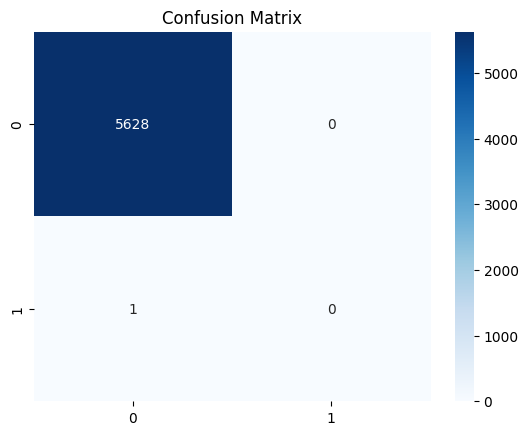

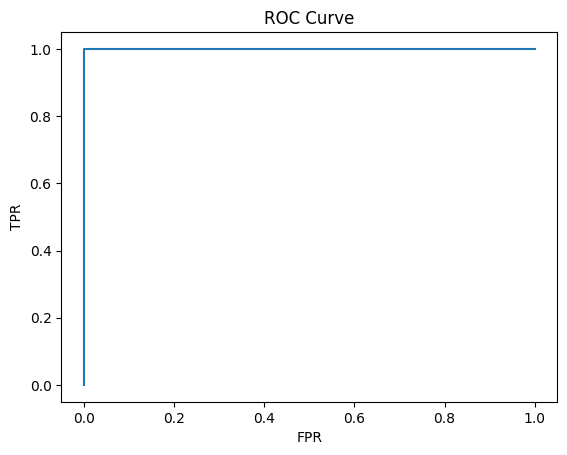

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

model.save("tf_model.keras")

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
df["cluster"] = kmeans.fit_predict(X)

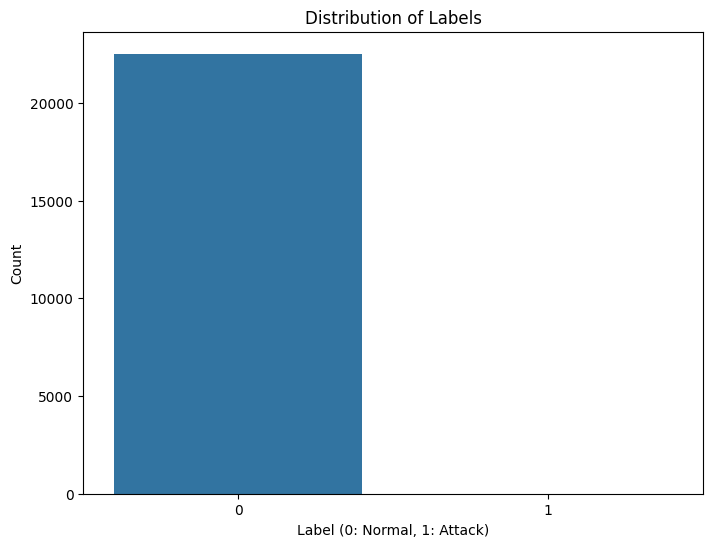

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['land'])
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Count')
plt.show()



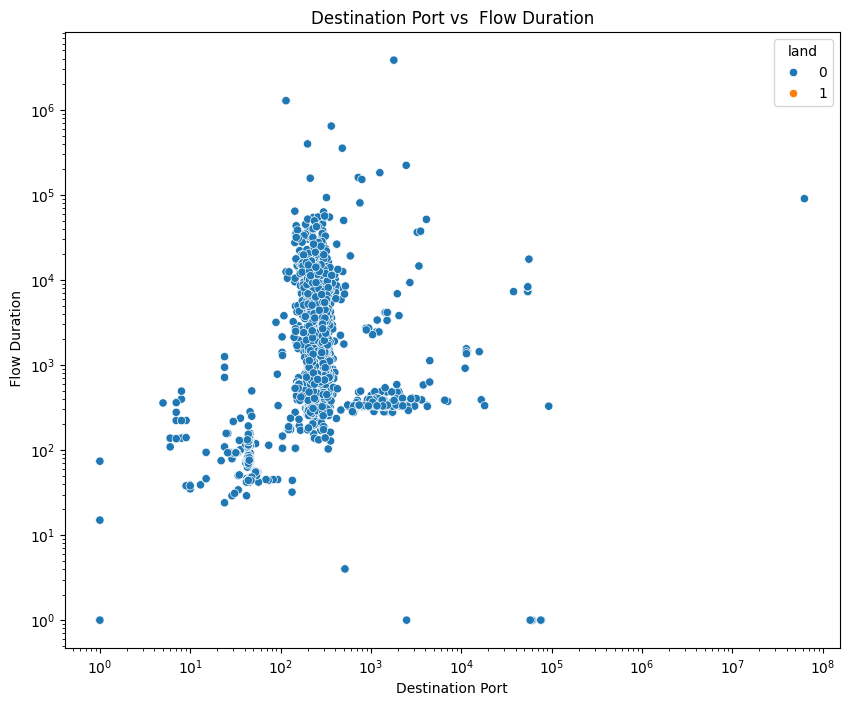

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='land', data=df.sample(n=min(len(df), 5000), random_state=42)) # Sample for better visualization if dataset is large
plt.title('Destination Port vs  Flow Duration')
plt.xlabel('Destination Port')
plt.ylabel(' Flow Duration')
plt.xscale('log')
plt.yscale('log')
plt.show()



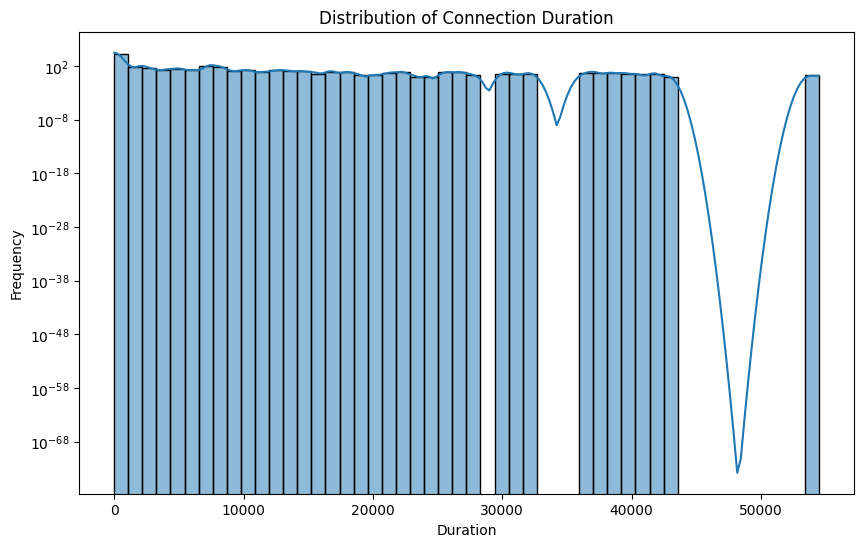

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Distribution of Connection Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

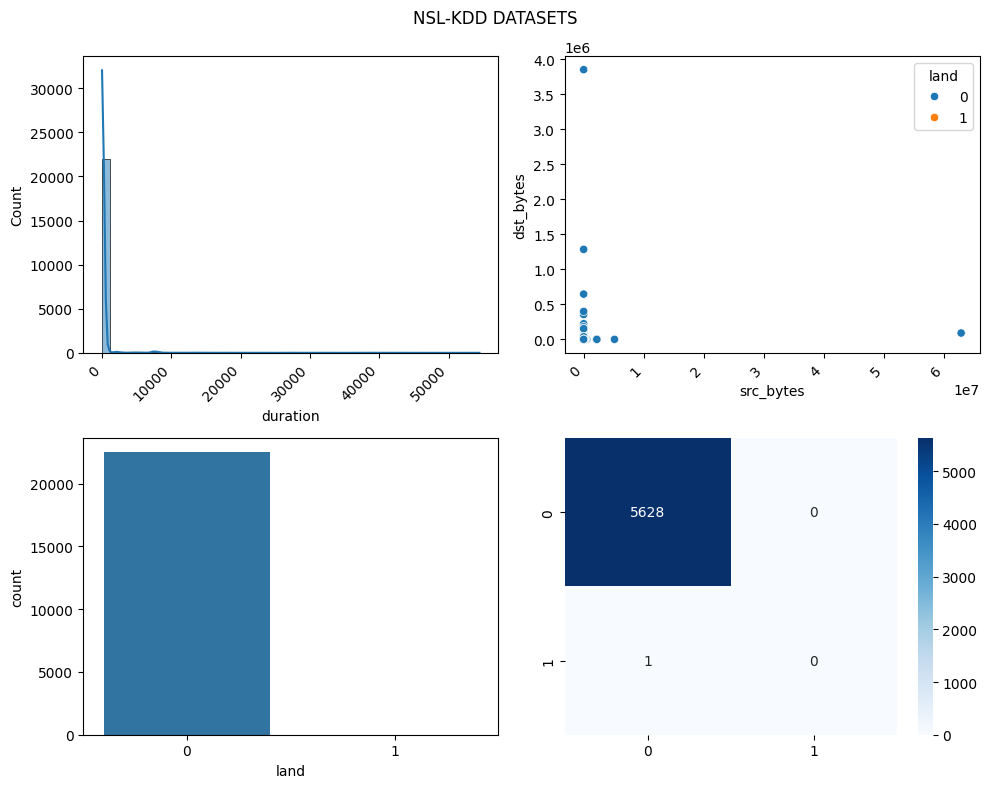

In [20]:
plt.figure(figsize=(10,8))
plt.suptitle("NSL-KDD DATASETS")
plt.subplot(2,2,1)
sns.histplot(df['duration'], bins=50, kde=True)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.subplot(2,2,2)
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='land', data=df.sample(n=min(len(df), 5000), random_state=42))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.subplot(2,2,3)
sns.countplot(x=df['land'])
plt.subplot(2,2,4)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.tight_layout()

plt.savefig('dashboard.png')
plt.show()